In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_dir = '/mnt/workspace/pytorch_tutorial/data/hymenoptera_data'
print(device)

cuda:0


In [5]:
# data augmentation and normalization for training 
# normalization for validation 
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'val' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
# datasets and dataloaders 
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size=8, 
                                              shuffle=True, num_workers=4)
               for x in ['train', 'val']}
dataset_sizes = {x : len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes    # ImageFolder utilities to obtain each subdirectory name as class name

print(class_names)
for cat in dataset_sizes:
    print(cat, dataset_sizes[cat])

['ants', 'bees']
train 247
val 153


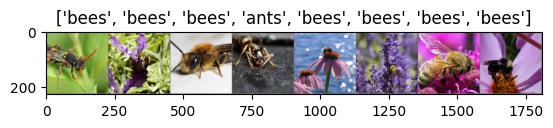

In [16]:
# visualization
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
# train function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [13]:
# fine tune the ConvNet
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.5818 Acc: 0.7469
val Loss: 0.2566 Acc: 0.9150

Epoch 1/49
----------
train Loss: 0.4442 Acc: 0.8327
val Loss: 0.2923 Acc: 0.9150

Epoch 2/49
----------
train Loss: 0.5487 Acc: 0.7592
val Loss: 0.3868 Acc: 0.8693

Epoch 3/49
----------
train Loss: 0.5315 Acc: 0.7918
val Loss: 0.2743 Acc: 0.8889

Epoch 4/49
----------
train Loss: 0.6027 Acc: 0.7918
val Loss: 0.9797 Acc: 0.6732

Epoch 5/49
----------
train Loss: 0.5427 Acc: 0.8082
val Loss: 0.2543 Acc: 0.8889

Epoch 6/49
----------
train Loss: 0.9213 Acc: 0.7633
val Loss: 0.9431 Acc: 0.7516

Epoch 7/49
----------
train Loss: 0.4819 Acc: 0.8245
val Loss: 0.2625 Acc: 0.9020

Epoch 8/49
----------
train Loss: 0.2247 Acc: 0.8980
val Loss: 0.2623 Acc: 0.9216

Epoch 9/49
----------
train Loss: 0.3387 Acc: 0.8571
val Loss: 0.2581 Acc: 0.8954

Epoch 10/49
----------
train Loss: 0.2553 Acc: 0.8857
val Loss: 0.2178 Acc: 0.9346

Epoch 11/49
----------
train Loss: 0.3671 Acc: 0.8367
val Loss: 0.2082 Acc: 0.9281

Ep

In [17]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# ConvNet as fixed feature extractor 
model_conv = models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False 

num_ftrs = model_conv.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_conv = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler_conv,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.5964 Acc: 0.6721
val Loss: 0.2959 Acc: 0.9150

Epoch 1/49
----------
train Loss: 0.4506 Acc: 0.7854
val Loss: 0.1972 Acc: 0.9542

Epoch 2/49
----------
train Loss: 0.4169 Acc: 0.7854
val Loss: 0.1946 Acc: 0.9477

Epoch 3/49
----------
train Loss: 0.3293 Acc: 0.8745
val Loss: 0.2967 Acc: 0.8693

Epoch 4/49
----------
train Loss: 0.3281 Acc: 0.8543
val Loss: 0.2618 Acc: 0.8954

Epoch 5/49
----------
train Loss: 0.3952 Acc: 0.8259
val Loss: 0.1862 Acc: 0.9412

Epoch 6/49
----------
train Loss: 0.2404 Acc: 0.8988
val Loss: 0.2961 Acc: 0.8824

Epoch 7/49
----------
train Loss: 0.2598 Acc: 0.8826
val Loss: 0.1993 Acc: 0.9412

Epoch 8/49
----------
train Loss: 0.2823 Acc: 0.8704
val Loss: 0.1790 Acc: 0.9477

Epoch 9/49
----------
train Loss: 0.2161 Acc: 0.8947
val Loss: 0.2119 Acc: 0.9281

Epoch 10/49
----------
train Loss: 0.2262 Acc: 0.8988
val Loss: 0.1860 Acc: 0.9412

Epoch 11/49
----------
train Loss: 0.2873 Acc: 0.8826
val Loss: 0.1935 Acc: 0.9346

Ep